<a href="https://colab.research.google.com/github/space-owner/Tensorflow-2/blob/main/Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ***Image Segmentation***
This post is **based on the Tensorflow tutorial** for study purposes. [Link](https://www.tensorflow.org/tutorials/images/segmentation)

***Learning Point:***
- **```  ```**


In [1]:
pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-u4bhild4
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-u4bhild4
  Created wheel for tensorflow-examples: filename=tensorflow_examples-5712126146d896d3c508161b942ffe6afe791f3e_-py3-none-any.whl size=271485 sha256=18a31af805a0ab554a7b6d45931f3f8282219252fe1a1b36f44bf4f8bc21c3c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-01740s12/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [2]:
import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

import tensorflow_datasets as tfds

In [3]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [4]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRNXYHM/oxford_iiit_pet-train.tfrecord


  0%|          | 0/3680 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteRNXYHM/oxford_iiit_pet-test.tfrecord


  0%|          | 0/3669 [00:00<?, ? examples/s]

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [17]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask

In [18]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], size=(128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], size=(128, 128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [19]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [20]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [21]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augment_inputs = preprocessing.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = preprocessing.RandomFlip(mode="horizontal", seed=seed)

    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        inputs = self.augment_labels(labels)
        return inputs, labels

In [32]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)

In [34]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True MAsk", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

>>> images.shape = (64, 128, 128, 1)
>>> masks.shape = (64, 128, 128, 1)


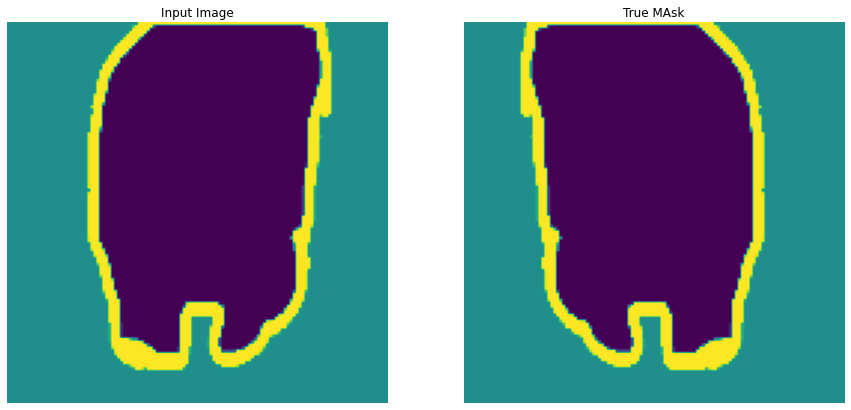

>>> images.shape = (64, 128, 128, 1)
>>> masks.shape = (64, 128, 128, 1)


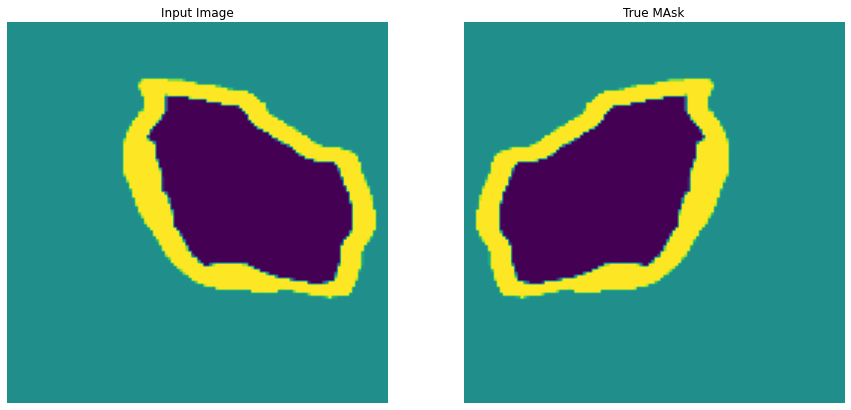

In [35]:
for images, masks in train_batches.take(2):
    print(">>> images.shape =", images.shape)
    print(">>> masks.shape =", masks.shape)
    sample_image, sample_mask = images[0], masks[0]
    display([sample_image, sample_mask])